In [2]:
import pandas as pd
# pd.options.plotting.backend = "plotly"
import os
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np
from zlib import crc32

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from scipy import stats

LOADING THE DATA 

In [3]:
HOUSING_PATH = r'C:\Users\zsena\Documents\GitHub\handson-ml2\datasets\housing'
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
housing_df = load_housing_data()
# housing_df = pd.read_csv(r'C:\Users\zsena\Documents\GitHub\handson-ml2\datasets\housing\housing.csv')
housing_df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
housing_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing_df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

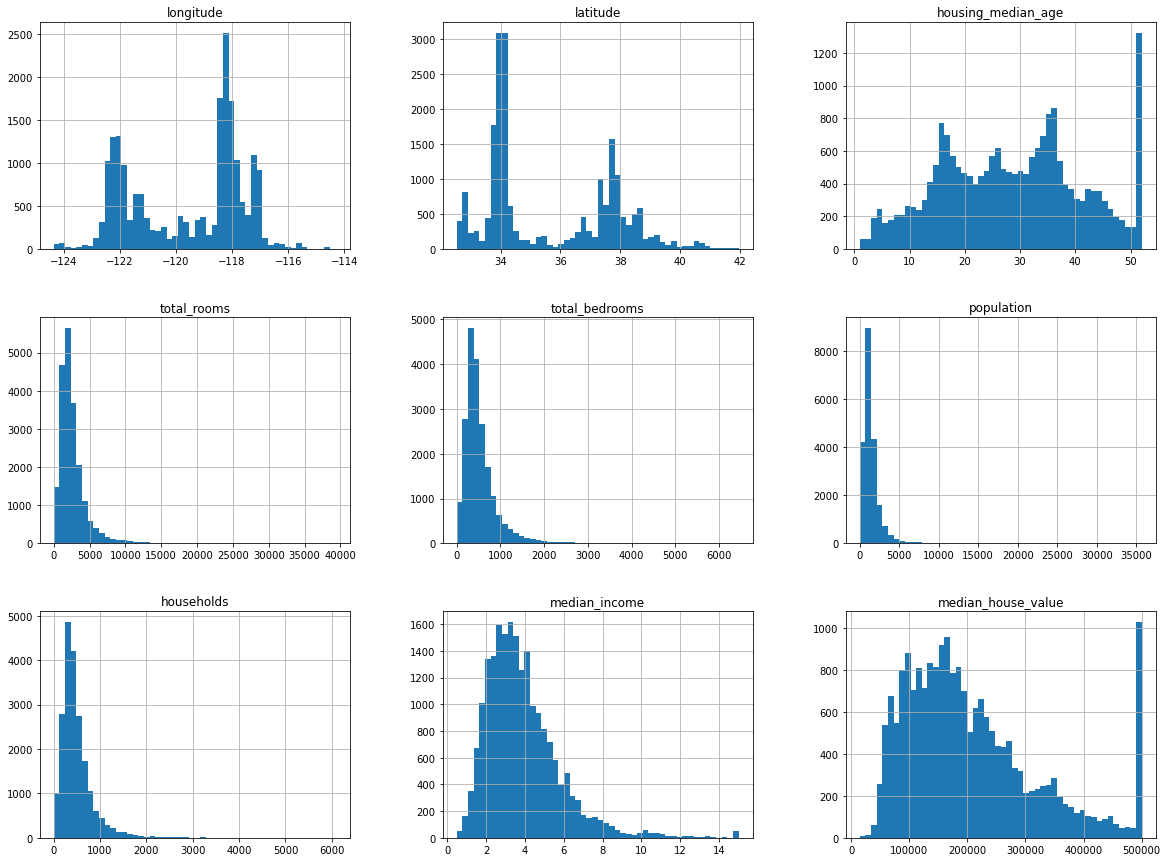

In [7]:
housing_df.hist(bins=50, figsize=(20,15))

CREATING A TEST SET

Random Sampling

In [8]:

def split_train_test(data, test_ratio):
    shuffled_indicies = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indicies = shuffled_indicies[:test_set_size]
    train_indicies = shuffled_indicies[test_set_size:]

    return data.iloc[train_indicies], data.iloc[test_indicies] #, print(shuffled_indicies)

In [9]:
train_set, test_set = split_train_test(housing_df, 0.2)

In [10]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing_df.reset_index()  #adds an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
housing_with_id['id'] = housing_df.longitude * 1000 + housing_df.latitude
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

with SKLearn

In [13]:
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=69)


Stratified Sampling (representative)

In [14]:
housing_df['income_cat'] = pd.cut(housing_df.median_income, 
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5])

px.histogram(housing_df.income_cat)

In [15]:
split = StratifiedShuffleSplit(n_splits =1, test_size = 0.2, random_state =69)
for train_index, test_index in split.split(housing_df, housing_df.income_cat):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [17]:
for set in (strat_train_set, strat_test_set):
    set.drop('income_cat', axis=1, inplace=True)

DATA EXPLORATION & VISUALIZATION

In [18]:
housing = strat_train_set.copy()

In [19]:
px.scatter(housing, x='longitude', y='latitude', width=600, opacity=.1)

In [20]:
px.scatter(housing, x='longitude', y='latitude', color='median_house_value', size='population', width=800, color_continuous_scale='jet')

In [21]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688762
total_rooms           0.138456
housing_median_age    0.104379
households            0.070768
total_bedrooms        0.054230
population           -0.021337
longitude            -0.043728
latitude             -0.147151
Name: median_house_value, dtype: float64

In [22]:
px.scatter_matrix(housing, width=800, height=800, dimensions= ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"])


array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

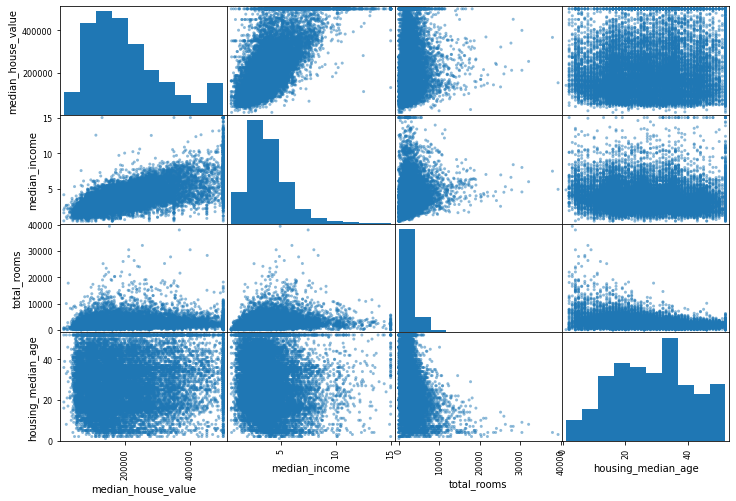

In [23]:
%matplotlib inline
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


In [24]:
px.scatter(housing, x='median_income', y='median_house_value', opacity=.1, width=600)

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


In [26]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688762
rooms_per_household         0.155150
total_rooms                 0.138456
housing_median_age          0.104379
households                  0.070768
total_bedrooms              0.054230
population                 -0.021337
longitude                  -0.043728
population_per_household   -0.051773
latitude                   -0.147151
bedrooms_per_room          -0.257702
Name: median_house_value, dtype: float64

PREPARING THE DATA

Dealing with NA values

In [27]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set.median_house_value.copy()

In [28]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14264 to 20478
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16346 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [29]:
# housing.dropna(subset=["total_bedrooms"]) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
# median = housing["total_bedrooms"].median() # option 3
# housing["total_bedrooms"].fillna(median, inplace=True) #median of train set, to use later in test set too


In [30]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_


array([-118.49  ,   34.26  ,   29.    , 2131.    ,  434.    , 1163.    ,
        410.    ,    3.5391])

In [31]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)
#imputer.fit_transform(housing_num)

housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


Text & Categorical Attributes

In [32]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

ocean_proximity
14264      NEAR OCEAN
18620      NEAR OCEAN
5895        <1H OCEAN
15473      NEAR OCEAN
18           NEAR BAY

In [33]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [4.],
       [0.],
       [4.],
       [3.],
       [0.],
       [3.],
       [0.],
       [0.],
       [1.]])

In [34]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [63]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

Custom Transformers

In [36]:
# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Transformation Pipelines

In [37]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [38]:
num_attribs = (list(housing_num))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

SELECT & TRAIN A MODEL

In [39]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [40]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [144449.79947921 305352.74668564 205585.83557488 234274.03620229
 183835.69698358]
Labels: [98000.0, 440500.0, 279300.0, 210400.0, 158700.0]


In [41]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68585.60589769523

In [42]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [43]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Scikit-Learn’s K-fold cross-validation feature. The follow‐
ing code randomly splits the training set into 10 distinct subsets called folds, then it
trains and evaluates the Decision Tree model 10 times, picking a different fold for
evaluation every time and training on the other 9 folds. The result is an array con‐
taining the 10 evaluation scores

In [44]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [45]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [66852.75418896 70922.45594696 69589.44140181 69562.26256491
 74808.45692126 68991.67089828 65624.247302   70794.92271979
 72747.48351411 69068.61666601]
Mean: 69896.23121240821
Standard deviation: 2516.7799645922337


In [46]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [64776.82128231 71434.61260144 69259.70906329 86886.38160915
 73411.87329533 69304.52090923 64996.06610765 71654.65094824
 68629.13271959 65951.41029341]
Mean: 70630.51788296315
Standard deviation: 6076.464812436113


In [47]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor()

In [48]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)


In [49]:
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [46951.65156112 52340.59475505 50078.93533722 50150.73303953
 52672.11346901 51875.9787011  49027.56589049 48004.15714607
 53457.07644245 48286.9743408 ]
Mean: 50284.57806828404
Standard deviation: 2108.6548838197177


FINE-TUNING A MODEL

In [50]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [51]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [52]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [53]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [ 10, 30, 60, 90], 'max_features': [6, 8, 10, 12, 24]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

c:\Users\zsena\anaconda3\envs\homl2\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


20 fits failed out of a total of 130.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zsena\anaconda3\envs\homl2\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zsena\anaconda3\envs\homl2\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\zsena\anaconda3\envs\homl2\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File 

{'max_features': 6, 'n_estimators': 90}

In [54]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=90)

In [55]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

51771.523863644055 {'max_features': 6, 'n_estimators': 10}
49881.07504529145 {'max_features': 6, 'n_estimators': 30}
49374.82118250749 {'max_features': 6, 'n_estimators': 60}
49253.04724189539 {'max_features': 6, 'n_estimators': 90}
52165.845267732795 {'max_features': 8, 'n_estimators': 10}
50082.41732949276 {'max_features': 8, 'n_estimators': 30}
49530.956887379434 {'max_features': 8, 'n_estimators': 60}
49334.16608851721 {'max_features': 8, 'n_estimators': 90}
51941.773873720456 {'max_features': 10, 'n_estimators': 10}
50458.89096806195 {'max_features': 10, 'n_estimators': 30}
49661.47856842145 {'max_features': 10, 'n_estimators': 60}
49509.64693854283 {'max_features': 10, 'n_estimators': 90}
52602.21813514431 {'max_features': 12, 'n_estimators': 10}
50366.98340926537 {'max_features': 12, 'n_estimators': 30}
49894.68759113777 {'max_features': 12, 'n_estimators': 60}
49745.52252409587 {'max_features': 12, 'n_estimators': 90}
nan {'max_features': 24, 'n_estimators': 10}
nan {'max_featu

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7C9E699D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7CA3C38B0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [57]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49128.00540538416 {'max_features': 7, 'n_estimators': 180}
51389.65412767579 {'max_features': 5, 'n_estimators': 15}
50380.827181042085 {'max_features': 3, 'n_estimators': 72}
50564.74957184342 {'max_features': 5, 'n_estimators': 21}
49276.7794872608 {'max_features': 7, 'n_estimators': 122}
50338.34474188085 {'max_features': 3, 'n_estimators': 75}
50215.965662965 {'max_features': 3, 'n_estimators': 88}
49365.8983236507 {'max_features': 5, 'n_estimators': 100}
50090.68263388676 {'max_features': 3, 'n_estimators': 150}
65313.00358854709 {'max_features': 5, 'n_estimators': 2}


Ensemble Methods

In [58]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.83400707e-02, 7.10496543e-02, 3.94206667e-02, 1.85593956e-02,
       1.68962760e-02, 1.77202004e-02, 1.59263531e-02, 3.27232741e-01,
       6.14568699e-02, 1.07089464e-01, 7.20537945e-02, 1.45356319e-02,
       1.50990662e-01, 2.60403896e-04, 2.86070916e-03, 5.60710680e-03])

In [59]:
extra_attribs =  ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.327232741397104, 'median_income'),
 (0.15099066172943637, 'INLAND'),
 (0.10708946386158322, 'pop_per_hhold'),
 (0.07834007071470948, 'longitude'),
 (0.0720537944528036, 'bedrooms_per_room'),
 (0.07104965432788178, 'latitude'),
 (0.06145686988579394, 'rooms_per_hhold'),
 (0.03942066671722421, 'housing_median_age'),
 (0.0185593955595552, 'total_rooms'),
 (0.017720200420192775, 'population'),
 (0.01689627601528123, 'total_bedrooms'),
 (0.015926353131234108, 'households'),
 (0.014535631929693111, '<1H OCEAN'),
 (0.00560710679686521, 'NEAR OCEAN'),
 (0.0028607091643684203, 'NEAR BAY'),
 (0.0002604038962733921, 'ISLAND')]

Evaluating on the test set

In [60]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))


In [61]:
final_rmse

47374.499976599895

In [62]:
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45265.56967503, 49393.46817202])

LAUNCH, MONITOR, MAINTAIN